# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

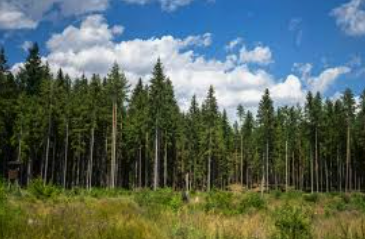

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [1]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras import models, layers

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

2025-09-15 02:05:49.378719: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-15 02:05:49.427673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-15 02:05:51.736929: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


In [4]:
counts

array([211840, 283301,  35754,   2747,   9493,  17367,  20510])

## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [5]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, stratify=y_sub, random_state=random_seed)
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (15383, 54)
X_test.shape  = (3846, 54)
y_train.shape = (15383,)
y_test.shape  = (3846,)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'X_train_scaled.shape = {X_train_scaled.shape}')
print(f'X_test_scaled.shape = {X_test_scaled.shape}')

X_train_scaled.shape = (15383, 54)
X_test_scaled.shape = (3846, 54)


In [7]:
y_train[:10]

array([5, 6, 1, 6, 0, 3, 5, 4, 3, 0], dtype=int32)

In [8]:
Counter(y_train)

Counter({np.int32(5): 2198,
         np.int32(1): 2198,
         np.int32(0): 2198,
         np.int32(2): 2198,
         np.int32(6): 2197,
         np.int32(3): 2197,
         np.int32(4): 2197})

In [9]:
Counter(y_test)

Counter({np.int32(3): 550,
         np.int32(4): 550,
         np.int32(6): 550,
         np.int32(1): 549,
         np.int32(0): 549,
         np.int32(5): 549,
         np.int32(2): 549})

### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



In [10]:
# Your code here
num_features = X_train_scaled.shape[1]
num_features

54

In [11]:
num_classes = len(np.unique(y_train))
num_classes

7

In [12]:
forest_model = models.Sequential([
    layers.Input(shape=(num_features,)),             # shape is a tuple (4,) = 1D array of length 4
    layers.Dense(64, activation='relu'),             # small hidden layer
    layers.Dense(32, activation='relu'),             # small hidden layer
    layers.Dense(num_classes, activation='softmax')  # 3 output classes
])

# Print out layers and stats
forest_model.summary()

2025-09-15 02:05:52.848589: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
opt = Adam(learning_rate=0.0001)                               # This is the default

forest_model.compile(loss="sparse_categorical_crossentropy",    # Used for classification with integer encoding of targets
                   optimizer=opt,       
                   metrics=["accuracy"]     
                  ) 


In [14]:
# Set the number of epochs and the batch size for training
epochs = 20
batch_size = 32

forest_history = forest_model.fit(X_train_scaled, 
                                  y_train, 
                                  epochs=epochs,           # Specify the number of iterations of training
                                  batch_size=batch_size,     # The mini-batch size, the default size is 32
                                  verbose=0                  # Set to 1 to see a trace
                                    )

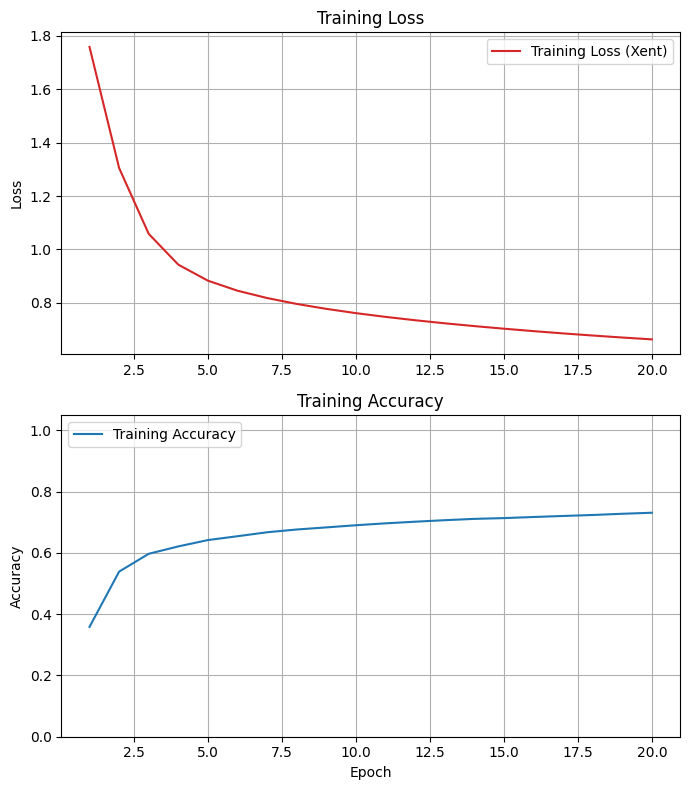

Final Training Loss:     0.6630
Final Training Accuracy: 0.7311


In [15]:
plot_history(forest_history)

In [16]:
j = forest_history.history["accuracy"][-1]
j

0.7311317920684814

In [17]:
# Set a1a to the final training accuracy at epoch 20

a1a = j            # Replace 0.0 with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7311


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!

In [19]:
type(X_train_scaled), type(y_train)


(numpy.ndarray, numpy.ndarray)

Epoch 1/20


3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5070 - loss: 1.3064
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6477 - loss: 0.8862
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6726 - loss: 0.8068
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6891 - loss: 0.7622
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7021 - loss: 0.7292
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7120 - loss: 0.7028
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7206 - loss: 0.6803
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7259 - loss: 0.6616
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7313 - loss: 0.6458
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7378 - loss: 0.6322
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7443 - loss: 0.6200
Epoch 12/20
3846/3846 ━━━━━━━━━━━━━━━━━━━

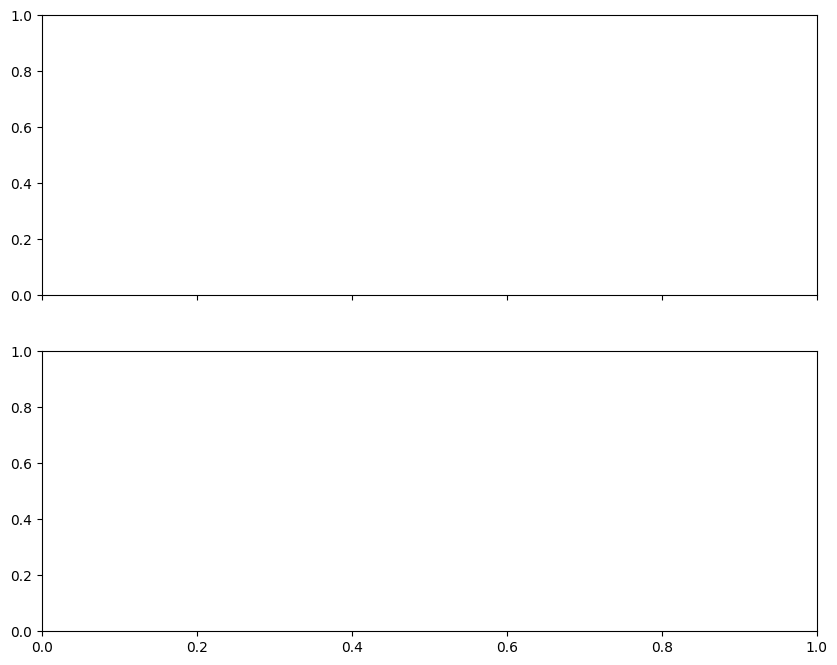

In [21]:
# Your code here
# Train for different batch sizes
batch_sizes = [4, 8, 16, 128]
histories = {}
tf.config.run_functions_eagerly(False)

for batch_size in batch_sizes:
    model = models.Sequential([
                        layers.Input(shape=(num_features,)),             # shape is a tuple (4,) = 1D array of length 4
                        layers.Dense(64, activation='relu'),             # small hidden layer
                        layers.Dense(32, activation='relu'),             # small hidden layer
                        layers.Dense(num_classes, activation='softmax')  # 3 output classes
                    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=batch_size,
        verbose=1
    )
    histories[batch_size] = history

# Plot learning curves
fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)



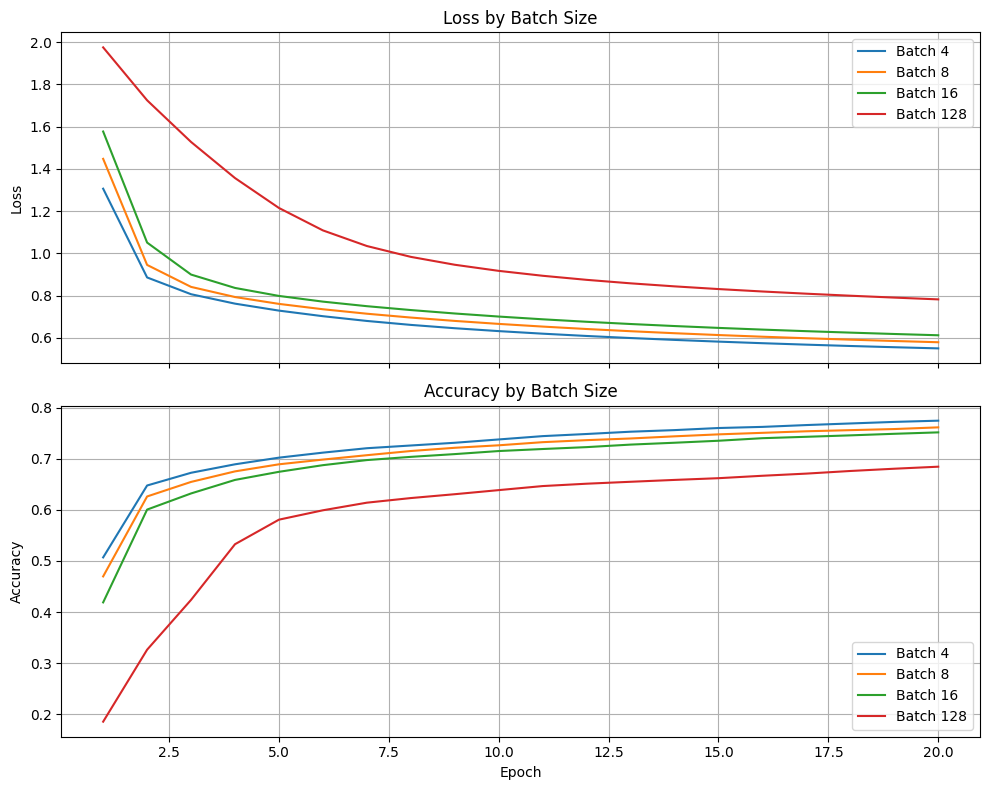

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)
for batch_size, history in histories.items():
    axs[0].plot(range(1,epochs+1),history.history['loss'], label=f'Batch {batch_size}')
    axs[1].plot(range(1,epochs+1),history.history['accuracy'], label=f'Batch {batch_size}')

axs[0].set_title('Loss by Batch Size')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Accuracy by Batch Size')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [24]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = 4            # Replace 0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [28]:
for batch_size, history in histories.items():
    print(f"Batch size {batch_size}")
    print(history.history['accuracy'][-1])


Batch size 4
0.7744913101196289
Batch size 8
0.7614249587059021
Batch size 16
0.7516089081764221
Batch size 128
0.6844568848609924


In [34]:
j = histories[4].history['accuracy'][-1]
j

0.7744913101196289

In [35]:
# Set a2b to the best accuracy score found

a2b = j             # Replace 0.0 with your answer

In [36]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7745


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.


In [41]:
# Your code here
loss_dict = {}
acc_dict = {}
#from tqdm.notebook import tqdm
from tqdm.auto import tqdm 
for lr in tqdm([1e-3, 5e-4, 1e-4,5e-5, 1e-5]):

    # Fresh model for each run
    model = models.Sequential([
                        layers.Input(shape=(num_features,)),             # shape is a tuple (4,) = 1D array of length 4
                        layers.Dense(64, activation='relu'),             # small hidden layer
                        layers.Dense(32, activation='relu'),             # small hidden layer
                        layers.Dense(num_classes, activation='softmax')  # 3 output classes
                    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        verbose=1
    )

    loss_dict[lr] = history.history["loss"]
    acc_dict[lr] = history.history["accuracy"]


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3655 - loss: 1.6640
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5525 - loss: 1.2410
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6047 - loss: 1.0419
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6284 - loss: 0.9466
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6440 - loss: 0.8906
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6579 - loss: 0.8529
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6684 - loss: 0.8246
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6759 - loss: 0.8018
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6827 - loss: 0.7825
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6901 - loss: 0.7659
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6960 - loss: 0.7512
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3804 - loss: 1.7052
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5442 - loss: 1.2553
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5983 - loss: 1.0304
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6280 - loss: 0.9283
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6464 - loss: 0.8720
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6630 - loss: 0.8352
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6731 - loss: 0.8081
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6834 - loss: 0.7869
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6889 - loss: 0.7692
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6949 - loss: 0.7538
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7001 - loss: 0.7399
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3815 - loss: 1.6669
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5927 - loss: 1.1973
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6295 - loss: 0.9818
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6508 - loss: 0.8922
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6622 - loss: 0.8436
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6735 - loss: 0.8112
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6837 - loss: 0.7869
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6916 - loss: 0.7672
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6971 - loss: 0.7505
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7006 - loss: 0.7360
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7066 - loss: 0.7233
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2999 - loss: 1.7890
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5583 - loss: 1.3118
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6050 - loss: 1.0489
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6249 - loss: 0.9363
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6386 - loss: 0.8811
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6523 - loss: 0.8460
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6641 - loss: 0.8200
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6739 - loss: 0.7994
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6822 - loss: 0.7823
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6891 - loss: 0.7675
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6947 - loss: 0.7541
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3283 - loss: 1.8035
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5576 - loss: 1.2717
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6053 - loss: 1.0175
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6319 - loss: 0.9164
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6540 - loss: 0.8652
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6696 - loss: 0.8327
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6772 - loss: 0.8087
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6812 - loss: 0.7892
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6848 - loss: 0.7726
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6893 - loss: 0.7576
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6947 - loss: 0.7441
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


100%|██████████| 5/5 [01:11<00:00, 14.23s/it]


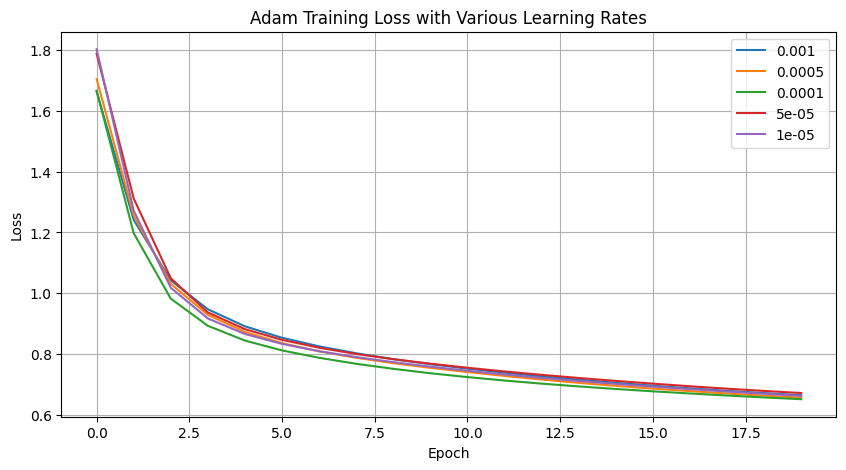

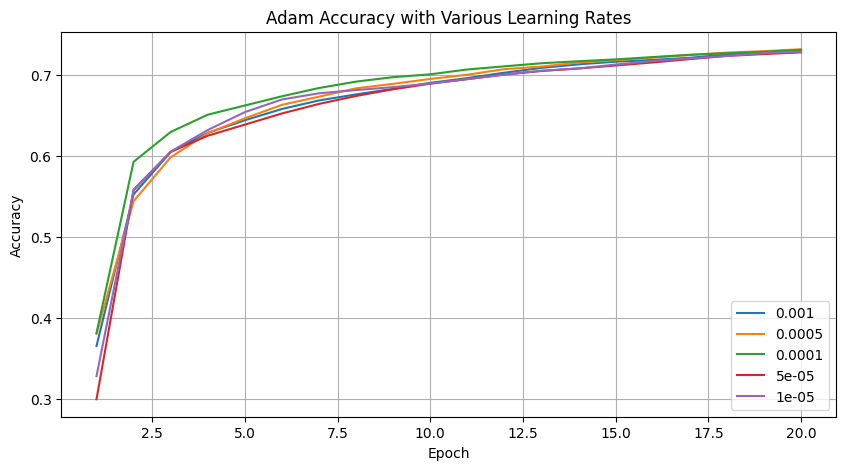

In [42]:
plt.figure(figsize=(10, 5))
for name, losses in loss_dict.items():
    plt.plot(losses, label=name)

plt.title("Adam Training Loss with Various Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for name, acc in acc_dict.items():
    plt.plot(range(1,epochs+1),acc, label=name)

plt.title("Adam Accuracy with Various Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
acc_dict

{0.001: [0.36553338170051575,
  0.5524930357933044,
  0.6046934723854065,
  0.6284210085868835,
  0.6439576148986816,
  0.6578691005706787,
  0.6684001684188843,
  0.6758759617805481,
  0.6827017068862915,
  0.6901124715805054,
  0.6959630846977234,
  0.7026587724685669,
  0.7085744142532349,
  0.7129298448562622,
  0.7161802053451538,
  0.7183904051780701,
  0.7210556864738464,
  0.7250211238861084,
  0.7283364534378052,
  0.7308717370033264],
 0.0005: [0.38035494089126587,
  0.5442371368408203,
  0.598257839679718,
  0.6280309557914734,
  0.646362841129303,
  0.6630046367645264,
  0.6730806827545166,
  0.6833517551422119,
  0.6888773441314697,
  0.6949229836463928,
  0.7001234889030457,
  0.707014262676239,
  0.7101995944976807,
  0.7151401042938232,
  0.7180004119873047,
  0.7212507128715515,
  0.7245010733604431,
  0.7274263501167297,
  0.7291815876960754,
  0.7315868139266968],
 0.0001: [0.38152506947517395,
  0.5927322506904602,
  0.6295260787010193,
  0.6508483290672302,
  0.662

In [51]:
for lr, accs in acc_dict.items():
    print(f"Learning rate: {lr}, Final accuracy: {accs[-1]:.4f}")

Learning rate: 0.001, Final accuracy: 0.7309
Learning rate: 0.0005, Final accuracy: 0.7316
Learning rate: 0.0001, Final accuracy: 0.7307
Learning rate: 5e-05, Final accuracy: 0.7277
Learning rate: 1e-05, Final accuracy: 0.7283


In [53]:
j = acc_dict[0.0005][-1]
j

0.7315868139266968

In [57]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = 5e-4             # Replace 0.0 with your answer

In [58]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0005


In [59]:
# Set a3b to the accuracy found by the best learning rate

a3b = j             # Replace 0.0 with your answer

In [60]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7316


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.

Exception ignored in: <function tqdm.__del__ at 0x79500504cb80>
Traceback (most recent call last):
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x79500504cb80>
Traceback (most recent call last):
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2850 - loss: 1.9050
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5366 - loss: 1.3528
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5946 - loss: 1.1114
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6131 - loss: 0.9873
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6315 - loss: 0.9147
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6481 - loss: 0.8691
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6597 - loss: 0.8377
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6695 - loss: 0.8135
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6749 - loss: 0.7935
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6822 - loss: 0.7765
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6891 - loss: 0.7616
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

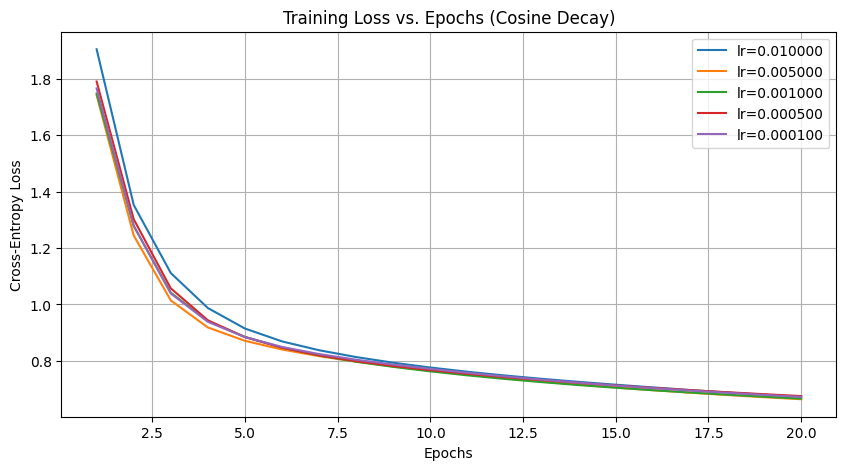

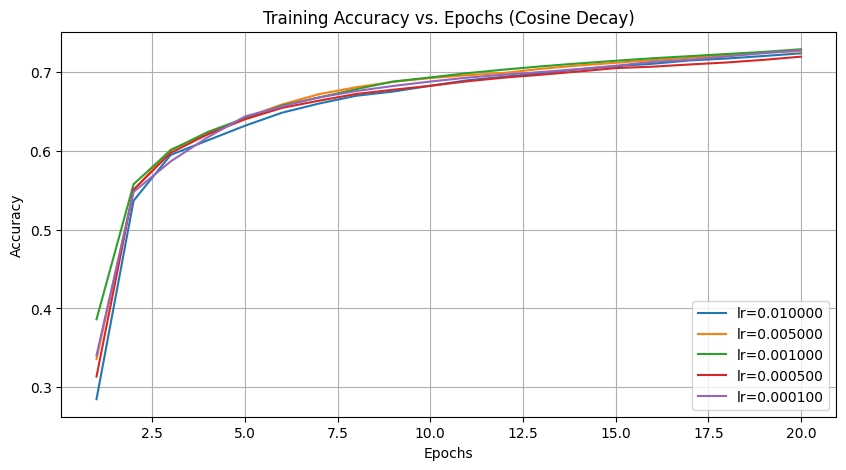

In [61]:
# Your code here

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch

init_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]  # five experiments

history_dict = {}

for lr0 in init_lrs:
    tf.keras.backend.clear_session()  # hygiene between runs

    # Cosine decay schedule for this run
    lr_schedule = CosineDecay(
        initial_learning_rate=lr0,
        decay_steps=total_steps
    )

    # Fresh model each time
    model = models.Sequential([
                        layers.Input(shape=(num_features,)),             # shape is a tuple (4,) = 1D array of length 4
                        layers.Dense(64, activation='relu'),             # small hidden layer
                        layers.Dense(32, activation='relu'),             # small hidden layer
                        layers.Dense(num_classes, activation='softmax')  # 3 output classes
                    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        verbose=1
    )

    # Store by decimal-form LR label (no sci notation)
    label = f"lr={lr0:.6f}"
    history_dict[label] = history.history

# --- Plots ---
plt.figure(figsize=(10, 5))
for name, hist in history_dict.items():
    plt.plot(range(1, epochs + 1), hist["loss"], label=name)
plt.title("Training Loss vs. Epochs (Cosine Decay)")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for name, hist in history_dict.items():
    plt.plot(range(1, epochs + 1), hist["accuracy"], label=name)
plt.title("Training Accuracy vs. Epochs (Cosine Decay)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# Find which initial LR gave the best final accuracy
best_lr = None
best_acc = -1.0

for lr_label, hist in history_dict.items():
    final_acc = hist["accuracy"][-1]   # last epoch's accuracy
    print(f"{lr_label} -> final acc {final_acc:.4f}")
    if final_acc > best_acc:
        best_acc = final_acc
        best_lr = lr_label
best_acc

lr=0.010000 -> final acc 0.7233
lr=0.005000 -> final acc 0.7260
lr=0.001000 -> final acc 0.7285
lr=0.000500 -> final acc 0.7191
lr=0.000100 -> final acc 0.7273


0.7285314798355103

In [63]:
best_lr

'lr=0.001000'

In [66]:
j = init_lrs[2]

In [67]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = j            # Replace 0.0 with your answer

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0000


In [68]:
# Set a4b to the best accuracy found

a4b = best_acc             # Replace 0.0 with your answer

In [69]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7285


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

In [70]:
# Your code here -- add as many cells as you need
forest_model = models.Sequential([
    layers.Input(shape=(num_features,)),             # shape is a tuple (4,) = 1D array of length 4
    layers.Dense(64, activation='relu'),             # small hidden layer
    layers.Dense(32, activation='relu'),             # small hidden layer
    layers.Dense(num_classes, activation='softmax')  # 3 output classes
])

# Print out layers and stats
forest_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
opt = Adam(learning_rate=0.0005)                               # This is the default

forest_model.compile(loss="sparse_categorical_crossentropy",    # Used for classification with integer encoding of targets
                   optimizer=opt,       
                   metrics=["accuracy"]     
                  ) 


In [72]:
epochs = 20

forest_history = forest_model.fit(X_train_scaled, 
                                  y_train, 
                                  epochs=epochs,           # Specify the number of iterations of training
                                  batch_size=4,     # The mini-batch size, the default size is 32
                                  verbose=0                  # Set to 1 to see a trace
                                    )

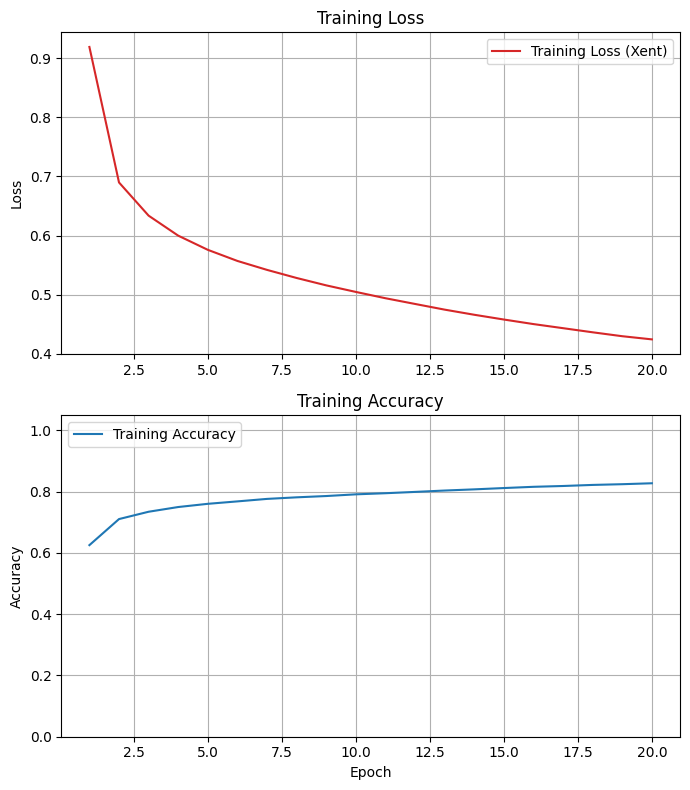

Final Training Loss:     0.4244
Final Training Accuracy: 0.8273


In [73]:
plot_history(forest_history)

In [75]:
j = forest_history.history["accuracy"][-1]

In [76]:
# Set a5a to the best training accuracy found by your best model

a5a = j             # Replace 0.0 with your answer

In [77]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8273


In [78]:
test_loss, test_accuracy = forest_model.evaluate(X_test_scaled, y_test,verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4733
Test Accuracy: 0.8107


In [79]:
# Set a5b to the test accuracy found by your best model

a5b = test_accuracy            # Replace 0.0 with your answer

In [80]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8107


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


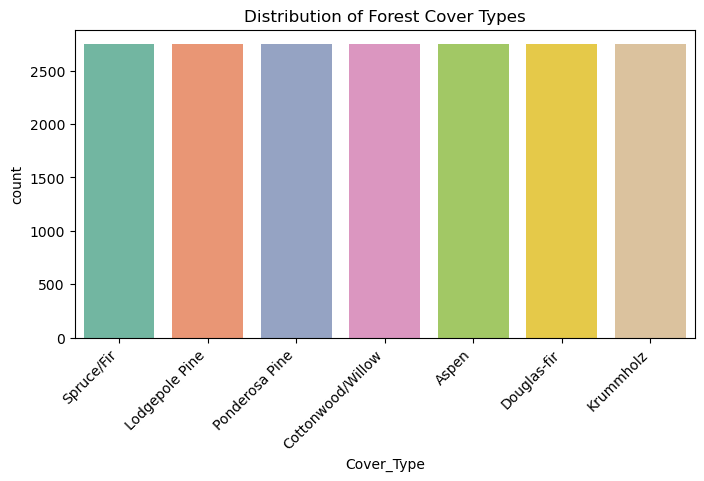

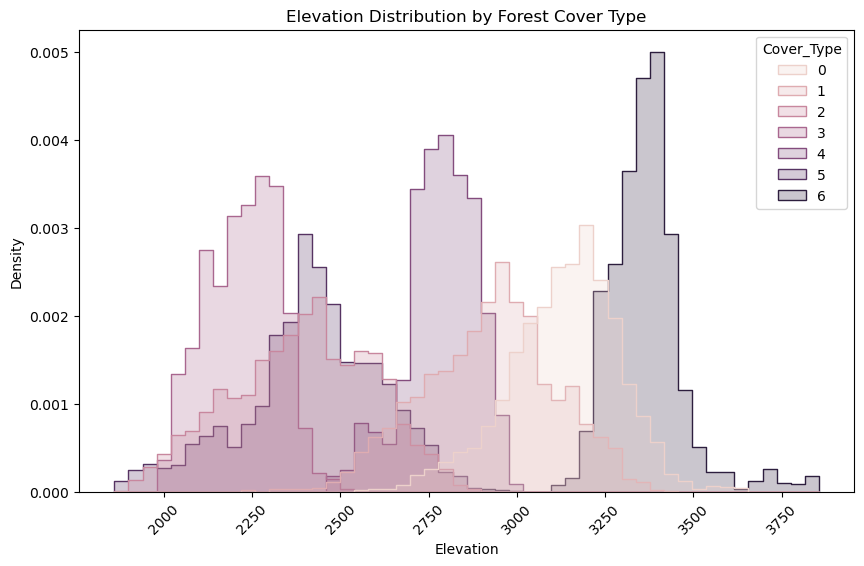

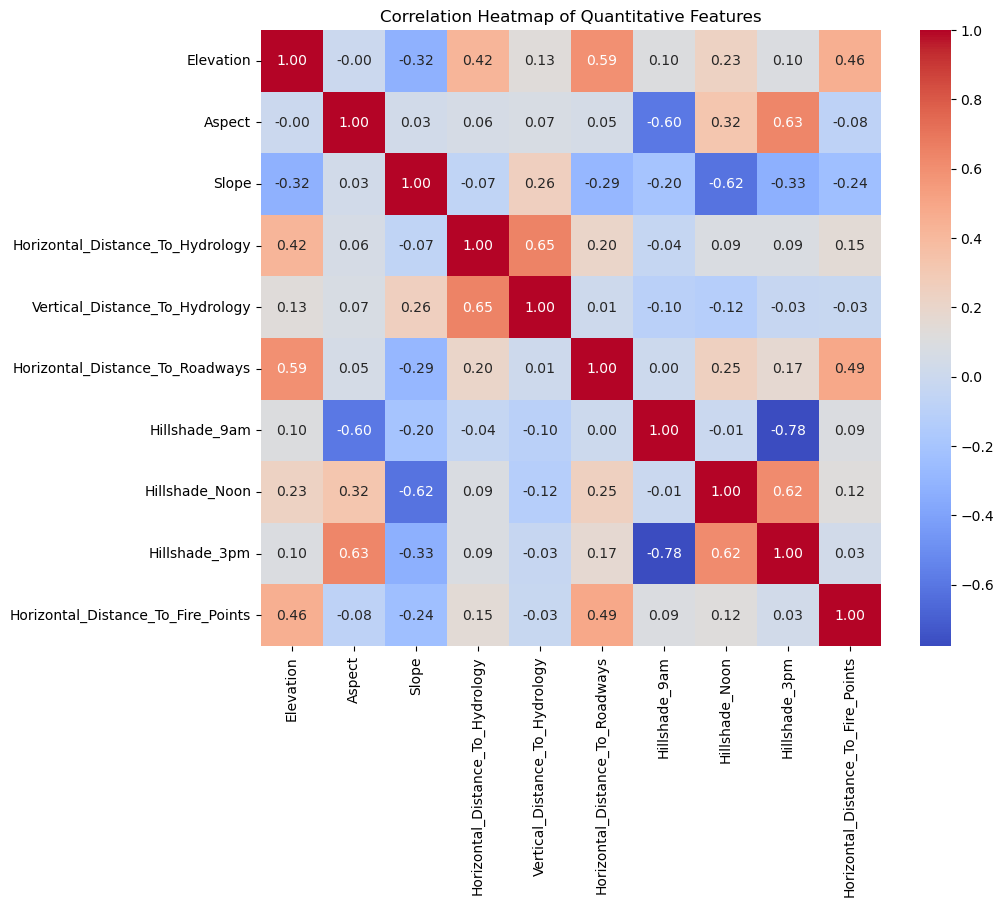

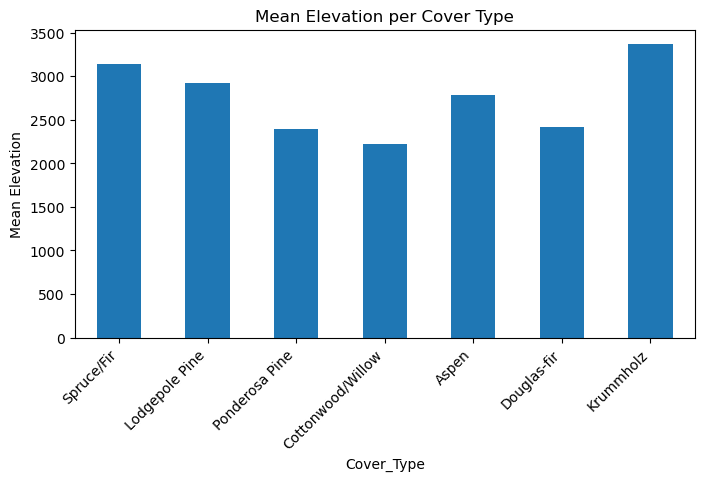

In [28]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
